####**dependencies + packages**

In [1]:
!apt install gdal-bin python-gdal python3-gdal 
# install rtree - geopandas requirement
!apt install python3-rtree 
# install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# install descartes - geopandas requirment
!pip install descartes 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-

In [2]:
from shapely.geometry import box, LineString, MultiLineString, Point, Polygon

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyproj

plt.style.use('default')

####**functions**

In [3]:
def merge_series_df(df, series_list, col_rename):
  for i in range(len(series_list)):
    df_series = pd.Series(series_list[i])
    df = pd.concat([df, df_series], axis = 1, sort= False)
    df = df.rename(columns= {0 : col_rename[i]})

  return df

####**mtl_trajet - trip info**
calculate the starting and ending point for each trip

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
# change directory
drive.mount('/content/drive', force_remount= True)
os.chdir('/content/drive/My Drive/MRP/to_be_submitted')

Mounted at /content/drive


In [6]:
# set path for shp files
mtl_trajet_json = 'mtl_trajet_2017_MRP.geojson'

# import file
mtl_trajet = gpd.read_file(mtl_trajet_json)

In [7]:
# convert start/end trip to geometry
trip_start = []
trip_end = []

for idx, row in mtl_trajet[['trip_start', 'trip_end']].iterrows():
  start_pts = row[0].split()
  start_pt1 = float(start_pts[1].replace('(', ''))
  start_pt2 = float(start_pts[2].replace(')', ''))

  trip_start.append(Point(start_pt1, start_pt2))

  end_pts = row[0].split()
  end_pt1 = float(end_pts[1].replace('(', ''))
  end_pt2 = float(end_pts[2].replace(')', ''))

  trip_end.append(Point(end_pt1, end_pt2))

trip_start_series = gpd.GeoSeries(trip_start)
trip_end_series = gpd.GeoSeries(trip_end)

del mtl_trajet['trip_start']
del mtl_trajet['trip_end']

mtl_trajet = merge_series_df(mtl_trajet, [trip_start_series, trip_end_series], ['trip_start', 'trip_end'])

In [8]:
mtl_trajet.head()

,id_trip,starttime,endtime,mode,purpose,num_modes_trans,trip_duration,trip_duration_secs,trip_duration_mins,day_of_week,hour,num_linestring,start_region_id,end_region_id,total_distance,num_coords_linestring,total_coords,DAUID_start,CDUID_start,CDNAME_start,ERUID_start,ERNAME_start,CMAUID_start,CMAPUID_start,CMANAME_start,CTUID_start,CTNAME_start,ADAUID_start,DAUID_end,CDUID_end,CDNAME_end,ERUID_end,ERNAME_end,CMAUID_end,CMAPUID_end,CMANAME_end,CTUID_end,CTNAME_end,ADAUID_end,geometry,trip_start,trip_end
0,150744,2017-09-18T10:02:50,2017-09-18T10:17:12,automobile,Reconduire / aller chercher une personne,1.0,0 days 00:14:22.000000000,862,14.366667,0,10,1,54,54,11.517727,21.0,278,24660491,2466,Montréal,2440,Montréal,462,24462,Montréal,4620266.00,0266.00,24660097,24661768,2466,Montréal,2440,Montréal,462,24462,Montréal,4620029.00,0029.00,24660072,"MULTILINESTRING ((-73.64638 45.54629, -73.6460...",POINT (-73.64638 45.54629),POINT (-73.64638 45.54629)
1,173651,2017-09-18T11:14:10,2017-09-18T12:01:46,automobile,Travail / Rendez-vous d'affaires,1.0,0 days 00:47:36.000000000,2856,47.600000,0,11,1,68,68,14.498038,6.0,450,24730119,2473,Thérèse-De Blainville,2455,Laurentides,462,24462,Montréal,4620710.11,0710.11,24730011,24650640,2465,Laval,2445,Laval,462,24462,Montréal,4620651.02,0651.02,24650035,"MULTILINESTRING ((-73.81487 45.64468, -73.8146...",POINT (-73.81487 45.64468),POINT (-73.81487 45.64468)
2,149086,2017-09-18T11:20:42,2017-09-18T12:10:14,public_transportation,Travail / Rendez-vous d'affaires,1.0,0 days 00:49:32.000000000,2972,49.533333,0,11,1,39,39,6.784823,nan,253,24661858,2466,Montréal,2440,Montréal,462,24462,Montréal,4620051.00,0051.00,24660115,24661283,2466,Montréal,2440,Montréal,462,24462,Montréal,4620062.00,0062.00,24660119,"MULTILINESTRING ((-73.56351 45.51645, -73.5634...",POINT (-73.56351 45.51645),POINT (-73.56351 45.51645)
3,358412,2017-09-18T11:27:38,2017-09-18T11:40:26,walk,Travail / Rendez-vous d'affaires,1.0,0 days 00:12:48.000000000,768,12.800000,0,11,1,55,55,0.839139,nan,58,24661827,2466,Montréal,2440,Montréal,462,24462,Montréal,4620174.00,0174.00,24660103,24661375,2466,Montréal,2440,Montréal,462,24462,Montréal,4620171.00,0171.00,24660114,"MULTILINESTRING ((-73.59024 45.53261, -73.5903...",POINT (-73.59024 45.53261),POINT (-73.59024 45.53261)
4,35763,2017-09-18T11:32:54,2017-09-18T12:04:07,automobile,Magasinage / emplettes,1.0,0 days 00:31:13.000000000,1873,31.216667,0,11,1,24,24,7.135372,nan,234,24670320,2467,Roussillon,2435,Montérégie,462,24462,Montréal,4620827.04,0827.04,24670001,24670007,2467,Roussillon,2435,Montérégie,462,24462,Montréal,4620827.03,0827.03,24670003,"MULTILINESTRING ((-73.47320 45.40843, -73.4730...",POINT (-73.47320 45.40843),POINT (-73.47320 45.40843)


In [ ]:
# query starting and end point of each trip
start_point = []
end_point = []

for idx, row in mtl_trajet[['geometry', 'num_linestring', 'total_coords']].iterrows():
  # get starting coords of trip
  start = row[0][0].coords[0]
  trip_start = Point(start[0], start[1])
  
  if row[1] == 1:
    # get ending coords of trip
    end = row[0][0].coords[row[2] - 1]
    trip_end = Point(end[0], end[1])
  else:
    # get no. of coordinates in last LINESTRING
    num_coordinates = len(row[0][row[1] - 1].coords) - 1
    end = row[0][row[1] - 1].coords[num_coordinates]
    trip_end = Point(end[0], end[1])
  # print('trip start : {}'.format(start_point))
  # print('trip end : {}'.format(end_point))
  start_point.append(trip_start)
  end_point.append(trip_end)

start_point_series = pd.Series(start_point)
end_point_series = pd.Series(end_point)

print(start_point_series.head())
print(end_point_series.head())

0             POINT (-73.646385 45.54629)
1    POINT (-73.81487199999999 45.644683)
2            POINT (-73.563513 45.516447)
3             POINT (-73.590244 45.53261)
4             POINT (-73.473197 45.40843)
dtype: object
0    POINT (-73.54531799999999 45.550661)
1    POINT (-73.80018800000001 45.556833)
2    POINT (-73.56519900000001 45.500887)
3    POINT (-73.59426999999999 45.526225)
4            POINT (-73.472673 45.408982)
dtype: object


In [ ]:
# merge & rename series
mtl_trajet = merge_series_df(mtl_trajet, [start_point_series, end_point_series], ['trip_start', 'trip_end'])

mtl_trajet['trip_start'] = mtl_trajet['trip_start'].astype('geometry')
mtl_trajet['trip_end'] = mtl_trajet['trip_end'].astype('geometry')

In [ ]:
mtl_trajet.head()

,id_trip,starttime,endtime,mode,purpose,num_modes_trans,trip_duration,trip_duration_secs,trip_duration_mins,day_of_week,hour,num_linestring,start_region_id,end_region_id,total_distance,num_coords_linestring,total_coords,geometry,DAUID_start,CDUID_start,CDNAME_start,ERUID_start,ERNAME_start,CMAUID_start,CMAPUID_start,CMANAME_start,CTUID_start,CTNAME_start,ADAUID_start,DAUID_end,CDUID_end,CDNAME_end,ERUID_end,ERNAME_end,CMAUID_end,CMAPUID_end,CMANAME_end,CTUID_end,CTNAME_end,ADAUID_end,trip_start,trip_end
0,150744,2017-09-18T10:02:50,2017-09-18T10:17:12,automobile,Reconduire / aller chercher une personne,1.0,0 days 00:14:22.000000000,862,14.366667,0,10,1,54,54,11.517727,21.0,278,"MULTILINESTRING ((-73.64638 45.54629, -73.6460...",24660491,2466,Montréal,2440,Montréal,462,24462,Montréal,4620266.00,0266.00,24660097,24660491,2466,Montréal,2440,Montréal,462,24462,Montréal,4620266.00,0266.00,24660097,POINT (-73.64638 45.54629),POINT (-73.54532 45.55066)
1,173651,2017-09-18T11:14:10,2017-09-18T12:01:46,automobile,Travail / Rendez-vous d'affaires,1.0,0 days 00:47:36.000000000,2856,47.600000,0,11,1,68,68,14.498038,6.0,450,"MULTILINESTRING ((-73.81487 45.64468, -73.8146...",24730119,2473,Thérèse-De Blainville,2455,Laurentides,462,24462,Montréal,4620710.11,0710.11,24730011,24730119,2473,Thérèse-De Blainville,2455,Laurentides,462,24462,Montréal,4620710.11,0710.11,24730011,POINT (-73.81487 45.64468),POINT (-73.80019 45.55683)
2,149086,2017-09-18T11:20:42,2017-09-18T12:10:14,public_transportation,Travail / Rendez-vous d'affaires,1.0,0 days 00:49:32.000000000,2972,49.533333,0,11,1,39,39,6.784823,nan,253,"MULTILINESTRING ((-73.56351 45.51645, -73.5634...",24661858,2466,Montréal,2440,Montréal,462,24462,Montréal,4620051.00,0051.00,24660115,24661858,2466,Montréal,2440,Montréal,462,24462,Montréal,4620051.00,0051.00,24660115,POINT (-73.56351 45.51645),POINT (-73.56520 45.50089)
3,358412,2017-09-18T11:27:38,2017-09-18T11:40:26,walk,Travail / Rendez-vous d'affaires,1.0,0 days 00:12:48.000000000,768,12.800000,0,11,1,55,55,0.839139,nan,58,"MULTILINESTRING ((-73.59024 45.53261, -73.5903...",24661827,2466,Montréal,2440,Montréal,462,24462,Montréal,4620174.00,0174.00,24660103,24661827,2466,Montréal,2440,Montréal,462,24462,Montréal,4620174.00,0174.00,24660103,POINT (-73.59024 45.53261),POINT (-73.59427 45.52622)
4,35763,2017-09-18T11:32:54,2017-09-18T12:04:07,automobile,Magasinage / emplettes,1.0,0 days 00:31:13.000000000,1873,31.216667,0,11,1,24,24,7.135372,nan,234,"MULTILINESTRING ((-73.47320 45.40843, -73.4730...",24670320,2467,Roussillon,2435,Montérégie,462,24462,Montréal,4620827.04,0827.04,24670001,24670320,2467,Roussillon,2435,Montérégie,462,24462,Montréal,4620827.04,0827.04,24670001,POINT (-73.47320 45.40843),POINT (-73.47267 45.40898)


In [ ]:
# export trip start for qgis processing
export = gpd.GeoDataFrame(mtl_trajet[['id_trip', 'trip_start']], geometry = 'trip_start')
export.to_file('mtl_trajet_SMT_trip_start_MRP.geojson', driver = 'GeoJSON')

In [ ]:
# export trip end for qgis processing
export = gpd.GeoDataFrame(mtl_trajet[['id_trip', 'trip_end']], geometry = 'trip_end')
export.to_file('mtl_trajet_SMT_trip_end_MRP.geojson', driver = 'GeoJSON')

In [ ]:
print ('no. of records : {}'.format(len(mtl_trajet)))

no. of records : 60995


In [ ]:
print ('no. of trips that started and ended in different location : {}'.format(len(mtl_trajet[mtl_trajet['trip_start'] == mtl_trajet['trip_end']])))
print ('no. of trips that started and ended different location : {}'.format(len(mtl_trajet[mtl_trajet['trip_start'] != mtl_trajet['trip_end']])))

no. of trips that started and ended in different location : 456
no. of trips that started and ended different location : 60539


####**census dissemination area**

In [9]:
# change directory
drive.mount('/content/drive', force_remount= True)
os.chdir('/content/drive/My Drive/MRP/census_boundary_files_2016/census_dissemination_area_2016')

Mounted at /content/drive


In [10]:
# set path for shp files
dissemination_area_shp_file = 'lda_000b16a_e.shp'

# import files
dissemination_area_shp = gpd.read_file(dissemination_area_shp_file)

In [11]:
# filter for quebec census tract
qbc_dissemination_area = dissemination_area_shp[dissemination_area_shp['PRNAME'] == 'Quebec / Québec']

In [12]:
# convert pts to lat/lon coordinates
qbc_dissemination_area['geometry'] = qbc_dissemination_area['geometry'].to_crs('epsg:4326') 
qbc_dissemination_area.crs = 'epsg:4326'
qbc_dissemination_area.head()

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,DAUID,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,CSDUID,CSDNAME,CSDTYPE,ERUID,ERNAME,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,CTUID,CTNAME,ADAUID,geometry
2807,24010037,24,Quebec / Québec,2401,Les Îles-de-la-Madeleine,TÉ,2401023,Les Îles-de-la-Madeleine,2401023,Les Îles-de-la-Madeleine,MÉ,2410,Gaspésie--Îles-de-la-Madeleine,998,6,None,None,None,None,None,None,24010001,"POLYGON ((-61.91808 47.26736, -61.91489 47.263..."
3580,24080061,24,Quebec / Québec,2408,Matane,MRC,2408053,Matane,2408053,Matane,V,2415,Bas-Saint-Laurent,403,3,403,24403,Matane,D,None,None,24080403,"POLYGON ((-67.52403 48.84167, -67.52398 48.841..."
3581,24080062,24,Quebec / Québec,2408,Matane,MRC,2408053,Matane,2408053,Matane,V,2415,Bas-Saint-Laurent,403,3,403,24403,Matane,D,None,None,24080403,"POLYGON ((-67.52831 48.83857, -67.52817 48.838..."
3582,24080063,24,Quebec / Québec,2408,Matane,MRC,2408053,Matane,2408053,Matane,V,2415,Bas-Saint-Laurent,403,3,403,24403,Matane,D,None,None,24080403,"POLYGON ((-67.53640 48.83081, -67.53654 48.830..."
3583,24080064,24,Quebec / Québec,2408,Matane,MRC,2408053,Matane,2408053,Matane,V,2415,Bas-Saint-Laurent,403,3,403,24403,Matane,D,None,None,24080403,"POLYGON ((-67.53060 48.84450, -67.53073 48.844..."


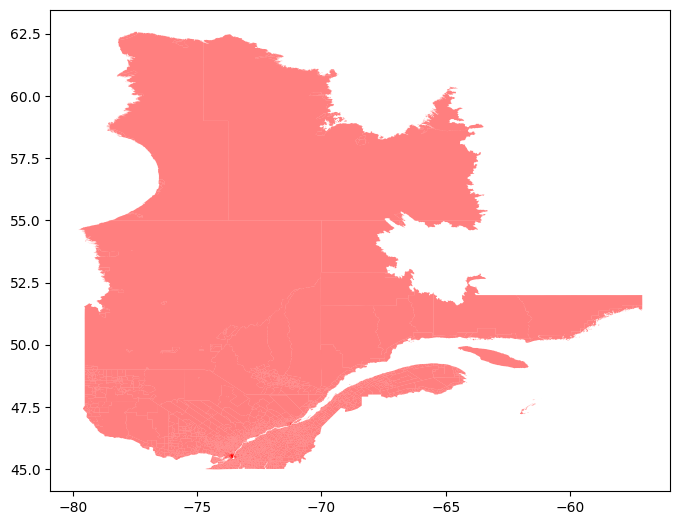

In [ ]:
# plot grid and SMT trips together
fig, ax = plt.subplots(figsize = (8,8))
qbc_dissemination_area.plot(ax = ax, color = 'r', alpha = 0.5)
plt.show()

In [ ]:
# query all dissemination areas within dataset
mtl_trajet_dissemination_start =  mtl_trajet['DAUID_start'].unique()
mtl_trajet_dissemination_end = mtl_trajet['DAUID_start'].unique()
mtl_trajet_dissemination = np.r_[mtl_trajet_dissemination_start, mtl_trajet_dissemination_end]

mtl_trajet_dissemination_DAUID = []
for i in mtl_trajet_dissemination:
  if i not in mtl_trajet_dissemination_DAUID:
    mtl_trajet_dissemination_DAUID.append(i)

print ('no. of unique DAUID regions : {}'.format(len(mtl_trajet_dissemination_DAUID)))

# calculate km2 of each region boundary
dissemination_area_poly_region = qbc_dissemination_area[qbc_dissemination_area['DAUID'].isin(mtl_trajet_dissemination_DAUID)]
dissemination_area_poly_region.crs = 'EPSG:4326'
dissemination_area_poly_region = dissemination_area_poly_region.to_crs('EPSG:2950')

dissemination_area_poly_region = dissemination_area_poly_region.area/10**6
dissemination_area_poly_region.head()

no. of unique DAUID regions : 3940


7916    11.239191
8132    12.257962
8155     0.098177
8156     0.092120
8157     0.080548
dtype: float64

In [ ]:
dissemination_area_poly_region.describe()

count    3939.000000
mean        0.828150
std         3.904210
min         0.004248
25%         0.049423
50%         0.100860
75%         0.209156
max        85.605646
dtype: float64

(array([3.76e+03, 6.60e+01, 3.50e+01, 1.80e+01, 1.10e+01, 1.40e+01,
        8.00e+00, 7.00e+00, 4.00e+00, 3.00e+00, 3.00e+00, 2.00e+00,
        3.00e+00, 1.00e+00, 2.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00]),
 array([4.24825988e-03, 3.42830418e+00, 6.85236011e+00, 1.02764160e+01,
        1.37004720e+01, 1.71245279e+01, 2.05485838e+01, 2.39726397e+01,
        2.73966957e+01, 3.08207516e+01, 3.42448075e+01, 3.76688634e+01,
        4.10929194e+01, 4.45169753e+01, 4.79410312e+01, 5.13650871e+01,
        5.47891431e+01, 5.82131990e+01, 6.16372549e+01, 6.50613108e+01,
        6.84853668e+01, 7.19094227e+01, 7.53334786e+01, 7.87575345e+01,
        8.21815905e+01, 8.56056464e+01]),
 <a list of 25 Patch objects>)

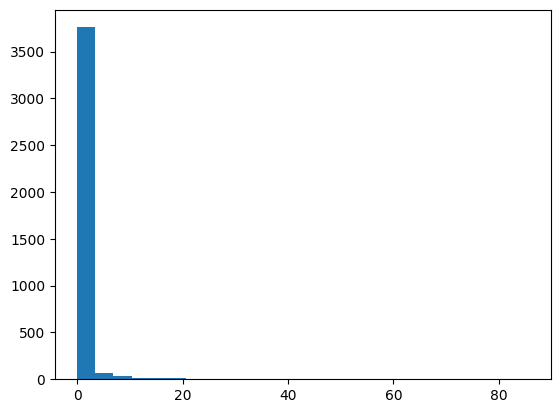

In [ ]:
plt.hist(dissemination_area_poly_region, bins= 25)

####**qgis - dissemination area**

In [ ]:
# change directory
drive.mount('/content/drive', force_remount= True)
os.chdir('/content/drive/My Drive/MRP/to_be_submitted')

Mounted at /content/drive


In [ ]:
del_cols = ['DAUID_start', 'CDUID_start', 'CDNAME_start', 'ERUID_start', 'ERNAME_start', 'CMAUID_start', 'CMAPUID_start', 'CMANAME_start', 
            'CTUID_start', 'CTNAME_start', 'ADAUID_start', 'DAUID_end', 'CDUID_end', 'CDNAME_end', 'ERUID_end', 'ERNAME_end', 'CMAUID_end', 
            'CMAPUID_end', 'CMANAME_end', 'CTUID_end', 'CTNAME_end', 'ADAUID_end']

mtl_trajet = mtl_trajet.drop(del_cols, axis= 1)
mtl_trajet.head()

,id_trip,starttime,endtime,mode,purpose,num_modes_trans,trip_duration,trip_duration_secs,trip_duration_mins,day_of_week,hour,num_linestring,start_region_id,end_region_id,total_distance,num_coords_linestring,total_coords,geometry,trip_start,trip_end
0,150744,2017-09-18T10:02:50,2017-09-18T10:17:12,automobile,Reconduire / aller chercher une personne,1.0,0 days 00:14:22.000000000,862,14.366667,0,10,1,54,54,11.517727,21.0,278,"MULTILINESTRING ((-73.64638 45.54629, -73.6460...",POINT (-73.64638 45.54629),POINT (-73.54532 45.55066)
1,173651,2017-09-18T11:14:10,2017-09-18T12:01:46,automobile,Travail / Rendez-vous d'affaires,1.0,0 days 00:47:36.000000000,2856,47.600000,0,11,1,68,68,14.498038,6.0,450,"MULTILINESTRING ((-73.81487 45.64468, -73.8146...",POINT (-73.81487 45.64468),POINT (-73.80019 45.55683)
2,149086,2017-09-18T11:20:42,2017-09-18T12:10:14,public_transportation,Travail / Rendez-vous d'affaires,1.0,0 days 00:49:32.000000000,2972,49.533333,0,11,1,39,39,6.784823,nan,253,"MULTILINESTRING ((-73.56351 45.51645, -73.5634...",POINT (-73.56351 45.51645),POINT (-73.56520 45.50089)
3,358412,2017-09-18T11:27:38,2017-09-18T11:40:26,walk,Travail / Rendez-vous d'affaires,1.0,0 days 00:12:48.000000000,768,12.800000,0,11,1,55,55,0.839139,nan,58,"MULTILINESTRING ((-73.59024 45.53261, -73.5903...",POINT (-73.59024 45.53261),POINT (-73.59427 45.52622)
4,35763,2017-09-18T11:32:54,2017-09-18T12:04:07,automobile,Magasinage / emplettes,1.0,0 days 00:31:13.000000000,1873,31.216667,0,11,1,24,24,7.135372,nan,234,"MULTILINESTRING ((-73.47320 45.40843, -73.4730...",POINT (-73.47320 45.40843),POINT (-73.47267 45.40898)


In [ ]:
# set path for shp files (dissemination area)
qgis_trip_start_json = 'mtl_trajet_SMT_region_id_start_MRP.geojson'
qgis_trip_end_json = 'mtl_trajet_SMT_region_id_end_MRP.geojson'

# import SHP file
qgis_trip_start = gpd.read_file(qgis_trip_start_json)

In [ ]:
# merge all relevant dissemination columns with mtl_trajet
qgis_cols = ['id_trip', 'DAUID', 'CDUID', 'CDNAME', 'ERUID', 'ERNAME', 'CMAUID', 'CMAPUID', 'CMANAME', 'CTUID', 'CTNAME', 'ADAUID']
mtl_trajet = mtl_trajet.merge(qgis_trip_start[qgis_cols], how = 'left', on = 'id_trip')
mtl_trajet = mtl_trajet.rename(columns = {'DAUID' : 'DAUID_start', 'CDUID' : 'CDUID_start', 'CDNAME' : 'CDNAME_start', 'ERUID' : 'ERUID_start',\
                                          'ERNAME' : 'ERNAME_start', 'CMAUID' : 'CMAUID_start', 'CMAPUID' : 'CMAPUID_start', \
                                          'CMANAME' : 'CMANAME_start', 'CTUID' : 'CTUID_start', 'CTNAME' : 'CTNAME_start', \
                                          'ADAUID' : 'ADAUID_start'})

mtl_trajet.head()

,id_trip,starttime,endtime,mode,purpose,num_modes_trans,trip_duration,trip_duration_secs,trip_duration_mins,day_of_week,hour,num_linestring,start_region_id,end_region_id,total_distance,num_coords_linestring,total_coords,geometry,trip_start,trip_end,DAUID_start,CDUID_start,CDNAME_start,ERUID_start,ERNAME_start,CMAUID_start,CMAPUID_start,CMANAME_start,CTUID_start,CTNAME_start,ADAUID_start
0,150744,2017-09-18T10:02:50,2017-09-18T10:17:12,automobile,Reconduire / aller chercher une personne,1.0,0 days 00:14:22.000000000,862,14.366667,0,10,1,54,54,11.517727,21.0,278,"MULTILINESTRING ((-73.64638 45.54629, -73.6460...",POINT (-73.64638 45.54629),POINT (-73.54532 45.55066),24660491,2466,Montréal,2440,Montréal,462,24462,Montréal,4620266.00,0266.00,24660097
1,173651,2017-09-18T11:14:10,2017-09-18T12:01:46,automobile,Travail / Rendez-vous d'affaires,1.0,0 days 00:47:36.000000000,2856,47.600000,0,11,1,68,68,14.498038,6.0,450,"MULTILINESTRING ((-73.81487 45.64468, -73.8146...",POINT (-73.81487 45.64468),POINT (-73.80019 45.55683),24730119,2473,Thérèse-De Blainville,2455,Laurentides,462,24462,Montréal,4620710.11,0710.11,24730011
2,149086,2017-09-18T11:20:42,2017-09-18T12:10:14,public_transportation,Travail / Rendez-vous d'affaires,1.0,0 days 00:49:32.000000000,2972,49.533333,0,11,1,39,39,6.784823,nan,253,"MULTILINESTRING ((-73.56351 45.51645, -73.5634...",POINT (-73.56351 45.51645),POINT (-73.56520 45.50089),24661858,2466,Montréal,2440,Montréal,462,24462,Montréal,4620051.00,0051.00,24660115
3,358412,2017-09-18T11:27:38,2017-09-18T11:40:26,walk,Travail / Rendez-vous d'affaires,1.0,0 days 00:12:48.000000000,768,12.800000,0,11,1,55,55,0.839139,nan,58,"MULTILINESTRING ((-73.59024 45.53261, -73.5903...",POINT (-73.59024 45.53261),POINT (-73.59427 45.52622),24661827,2466,Montréal,2440,Montréal,462,24462,Montréal,4620174.00,0174.00,24660103
4,35763,2017-09-18T11:32:54,2017-09-18T12:04:07,automobile,Magasinage / emplettes,1.0,0 days 00:31:13.000000000,1873,31.216667,0,11,1,24,24,7.135372,nan,234,"MULTILINESTRING ((-73.47320 45.40843, -73.4730...",POINT (-73.47320 45.40843),POINT (-73.47267 45.40898),24670320,2467,Roussillon,2435,Montérégie,462,24462,Montréal,4620827.04,0827.04,24670001


In [ ]:
# verify that each pts is contained within DAUID polygon
counter = 0

for idx, row in qgis_trip_start[['id_trip', 'DAUID', 'geometry']].iterrows():
  geo_loc = row[2]
  DAUID_geometry = qbc_dissemination_area['geometry'][qbc_dissemination_area['DAUID'] == row[1]]
  if DAUID_geometry.contains(geo_loc).values[0] == True:
    counter +=1

print ('no. of correct intersections : {}%'.format((counter/len(qgis_trip_start)*100)))

no. of correct intersections : 100.0%


In [ ]:
# import qgis_trip_end file
qgis_trip_end = gpd.read_file(qgis_trip_end_json)

In [ ]:
# merge all relevant dissemination columns with mtl_trajet
mtl_trajet = mtl_trajet.merge(qgis_trip_end[qgis_cols], how = 'left', on = 'id_trip')
mtl_trajet = mtl_trajet.rename(columns = {'DAUID' : 'DAUID_end', 'CDUID' : 'CDUID_end', 'CDNAME' : 'CDNAME_end', 'ERUID' : 'ERUID_end',\
                                          'ERNAME' : 'ERNAME_end', 'CMAUID' : 'CMAUID_end', 'CMAPUID' : 'CMAPUID_end', \
                                          'CMANAME' : 'CMANAME_end', 'CTUID' : 'CTUID_end', 'CTNAME' : 'CTNAME_end', \
                                          'ADAUID' : 'ADAUID_end'})

mtl_trajet.head()

,id_trip,starttime,endtime,mode,purpose,num_modes_trans,trip_duration,trip_duration_secs,trip_duration_mins,day_of_week,hour,num_linestring,start_region_id,end_region_id,total_distance,num_coords_linestring,total_coords,geometry,trip_start,trip_end,DAUID_start,CDUID_start,CDNAME_start,ERUID_start,ERNAME_start,CMAUID_start,CMAPUID_start,CMANAME_start,CTUID_start,CTNAME_start,ADAUID_start,DAUID_end,CDUID_end,CDNAME_end,ERUID_end,ERNAME_end,CMAUID_end,CMAPUID_end,CMANAME_end,CTUID_end,CTNAME_end,ADAUID_end
0,150744,2017-09-18T10:02:50,2017-09-18T10:17:12,automobile,Reconduire / aller chercher une personne,1.0,0 days 00:14:22.000000000,862,14.366667,0,10,1,54,54,11.517727,21.0,278,"MULTILINESTRING ((-73.64638 45.54629, -73.6460...",POINT (-73.64638 45.54629),POINT (-73.54532 45.55066),24660491,2466,Montréal,2440,Montréal,462,24462,Montréal,4620266.00,0266.00,24660097,24661768,2466,Montréal,2440,Montréal,462,24462,Montréal,4620029.00,0029.00,24660072
1,173651,2017-09-18T11:14:10,2017-09-18T12:01:46,automobile,Travail / Rendez-vous d'affaires,1.0,0 days 00:47:36.000000000,2856,47.600000,0,11,1,68,68,14.498038,6.0,450,"MULTILINESTRING ((-73.81487 45.64468, -73.8146...",POINT (-73.81487 45.64468),POINT (-73.80019 45.55683),24730119,2473,Thérèse-De Blainville,2455,Laurentides,462,24462,Montréal,4620710.11,0710.11,24730011,24650640,2465,Laval,2445,Laval,462,24462,Montréal,4620651.02,0651.02,24650035
2,149086,2017-09-18T11:20:42,2017-09-18T12:10:14,public_transportation,Travail / Rendez-vous d'affaires,1.0,0 days 00:49:32.000000000,2972,49.533333,0,11,1,39,39,6.784823,nan,253,"MULTILINESTRING ((-73.56351 45.51645, -73.5634...",POINT (-73.56351 45.51645),POINT (-73.56520 45.50089),24661858,2466,Montréal,2440,Montréal,462,24462,Montréal,4620051.00,0051.00,24660115,24661283,2466,Montréal,2440,Montréal,462,24462,Montréal,4620062.00,0062.00,24660119
3,358412,2017-09-18T11:27:38,2017-09-18T11:40:26,walk,Travail / Rendez-vous d'affaires,1.0,0 days 00:12:48.000000000,768,12.800000,0,11,1,55,55,0.839139,nan,58,"MULTILINESTRING ((-73.59024 45.53261, -73.5903...",POINT (-73.59024 45.53261),POINT (-73.59427 45.52622),24661827,2466,Montréal,2440,Montréal,462,24462,Montréal,4620174.00,0174.00,24660103,24661375,2466,Montréal,2440,Montréal,462,24462,Montréal,4620171.00,0171.00,24660114
4,35763,2017-09-18T11:32:54,2017-09-18T12:04:07,automobile,Magasinage / emplettes,1.0,0 days 00:31:13.000000000,1873,31.216667,0,11,1,24,24,7.135372,nan,234,"MULTILINESTRING ((-73.47320 45.40843, -73.4730...",POINT (-73.47320 45.40843),POINT (-73.47267 45.40898),24670320,2467,Roussillon,2435,Montérégie,462,24462,Montréal,4620827.04,0827.04,24670001,24670007,2467,Roussillon,2435,Montérégie,462,24462,Montréal,4620827.03,0827.03,24670003


In [ ]:
# verify that each pts is contained within DAUID polygon
counter = 0

for idx, row in qgis_trip_end[['id_trip', 'DAUID', 'geometry']].iterrows():
  geo_loc = row[2]
  DAUID_geometry = qbc_dissemination_area['geometry'][qbc_dissemination_area['DAUID'] == row[1]]
  if DAUID_geometry.contains(geo_loc).values[0] == True:
    counter +=1

print ('no. of correct intersections : {}%'.format((counter/len(qgis_trip_end)*100)))

no. of correct intersections : 100.0%


In [ ]:
print ('no. of trips that started/ended in same dissemination area : {}'
.format(len(mtl_trajet[mtl_trajet['DAUID_start'] != mtl_trajet['DAUID_end']])))

no. of trips that started/ended in same dissemination area : 57713


In [ ]:
print ('no. of trips that started/ended in same census tract area : {}'
.format(len(mtl_trajet[mtl_trajet['CTUID_start'] == mtl_trajet['CTUID_end']])))

no. of trips that started/ended in same census tract area : 6328


In [ ]:
print ('no. of trips that started outside of census tract area : {}'.format(len(mtl_trajet[mtl_trajet['CTUID_start'].isna()])))
print ('no. of trips that ended outside of census tract area : {}'.format(len(mtl_trajet[mtl_trajet['CTUID_end'].isna()])))

no. of trips that started outside of census tract area : 254
no. of trips that ended outside of census tract area : 170


In [ ]:
print ('no. of trips outside of census tract area : {}'.format(len(mtl_trajet[mtl_trajet['CTUID_start'] == 'None'])))

no. of trips outside of census tract area : 0


In [ ]:
mtl_trajet.head()

,id_trip,starttime,endtime,mode,purpose,num_modes_trans,trip_duration,trip_duration_secs,trip_duration_mins,day_of_week,hour,num_linestring,start_region_id,end_region_id,total_distance,num_coords_linestring,total_coords,geometry,trip_start,trip_end,DAUID_start,CDUID_start,CDNAME_start,ERUID_start,ERNAME_start,CMAUID_start,CMAPUID_start,CMANAME_start,CTUID_start,CTNAME_start,ADAUID_start,DAUID_end,CDUID_end,CDNAME_end,ERUID_end,ERNAME_end,CMAUID_end,CMAPUID_end,CMANAME_end,CTUID_end,CTNAME_end,ADAUID_end
0,150744,2017-09-18T10:02:50,2017-09-18T10:17:12,automobile,Reconduire / aller chercher une personne,1.0,0 days 00:14:22.000000000,862,14.366667,0,10,1,54,54,11.517727,21.0,278,"MULTILINESTRING ((-73.64638 45.54629, -73.6460...",POINT (-73.64638 45.54629),POINT (-73.54532 45.55066),24660491,2466,Montréal,2440,Montréal,462,24462,Montréal,4620266.00,0266.00,24660097,24661768,2466,Montréal,2440,Montréal,462,24462,Montréal,4620029.00,0029.00,24660072
1,173651,2017-09-18T11:14:10,2017-09-18T12:01:46,automobile,Travail / Rendez-vous d'affaires,1.0,0 days 00:47:36.000000000,2856,47.600000,0,11,1,68,68,14.498038,6.0,450,"MULTILINESTRING ((-73.81487 45.64468, -73.8146...",POINT (-73.81487 45.64468),POINT (-73.80019 45.55683),24730119,2473,Thérèse-De Blainville,2455,Laurentides,462,24462,Montréal,4620710.11,0710.11,24730011,24650640,2465,Laval,2445,Laval,462,24462,Montréal,4620651.02,0651.02,24650035
2,149086,2017-09-18T11:20:42,2017-09-18T12:10:14,public_transportation,Travail / Rendez-vous d'affaires,1.0,0 days 00:49:32.000000000,2972,49.533333,0,11,1,39,39,6.784823,nan,253,"MULTILINESTRING ((-73.56351 45.51645, -73.5634...",POINT (-73.56351 45.51645),POINT (-73.56520 45.50089),24661858,2466,Montréal,2440,Montréal,462,24462,Montréal,4620051.00,0051.00,24660115,24661283,2466,Montréal,2440,Montréal,462,24462,Montréal,4620062.00,0062.00,24660119
3,358412,2017-09-18T11:27:38,2017-09-18T11:40:26,walk,Travail / Rendez-vous d'affaires,1.0,0 days 00:12:48.000000000,768,12.800000,0,11,1,55,55,0.839139,nan,58,"MULTILINESTRING ((-73.59024 45.53261, -73.5903...",POINT (-73.59024 45.53261),POINT (-73.59427 45.52622),24661827,2466,Montréal,2440,Montréal,462,24462,Montréal,4620174.00,0174.00,24660103,24661375,2466,Montréal,2440,Montréal,462,24462,Montréal,4620171.00,0171.00,24660114
4,35763,2017-09-18T11:32:54,2017-09-18T12:04:07,automobile,Magasinage / emplettes,1.0,0 days 00:31:13.000000000,1873,31.216667,0,11,1,24,24,7.135372,nan,234,"MULTILINESTRING ((-73.47320 45.40843, -73.4730...",POINT (-73.47320 45.40843),POINT (-73.47267 45.40898),24670320,2467,Roussillon,2435,Montérégie,462,24462,Montréal,4620827.04,0827.04,24670001,24670007,2467,Roussillon,2435,Montérégie,462,24462,Montréal,4620827.03,0827.03,24670003


####**export file**

In [ ]:
# change directory
drive.mount('/content/drive', force_remount= True)
os.chdir('/content/drive/My Drive/MRP/to_be_submitted')

Mounted at /content/drive


In [ ]:
mtl_trajet.dtypes

id_trip                     int64
starttime                  object
endtime                    object
mode                       object
purpose                    object
num_modes_trans           float64
trip_duration              object
trip_duration_secs          int64
trip_duration_mins        float64
day_of_week                 int64
hour                        int64
num_linestring              int64
start_region_id             int64
end_region_id               int64
total_distance            float64
num_coords_linestring      object
total_coords                int64
geometry                 geometry
trip_start               geometry
trip_end                 geometry
DAUID_start                object
CDUID_start                object
CDNAME_start               object
ERUID_start                object
ERNAME_start               object
CMAUID_start               object
CMAPUID_start              object
CMANAME_start              object
CTUID_start                object
CTNAME_start  

In [ ]:
mtl_trajet['trip_start'] = mtl_trajet['trip_start'].astype('str')
mtl_trajet['trip_end'] = mtl_trajet['trip_end'].astype('str')

mtl_trajet.to_file('mtl_trajet_2017_MRP.geojson', driver = 'GeoJSON')

####**choropleth - trip start**

In [13]:
# create frequency count for trip starts by DAUID
trip_start_counts = mtl_trajet['DAUID_start'].value_counts().reset_index(name = 'count')
trip_start_counts = trip_start_counts.rename(columns= {'index' : 'DAUID'})
trip_start_counts['DAUID'] = trip_start_counts['DAUID'].astype(object)
trip_start_counts.head()

,DAUID,count
0,24661283,2104
1,24663442,662
2,24661858,617
3,24661104,543
4,24662114,497


In [ ]:
len(trip_start_counts)

3939

(array([3.825e+03, 8.900e+01, 9.000e+00, 4.000e+00, 5.000e+00, 3.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([1.00000e+00, 8.51200e+01, 1.69240e+02, 2.53360e+02, 3.37480e+02,
        4.21600e+02, 5.05720e+02, 5.89840e+02, 6.73960e+02, 7.58080e+02,
        8.42200e+02, 9.26320e+02, 1.01044e+03, 1.09456e+03, 1.17868e+03,
        1.26280e+03, 1.34692e+03, 1.43104e+03, 1.51516e+03, 1.59928e+03,
        1.68340e+03, 1.76752e+03, 1.85164e+03, 1.93576e+03, 2.01988e+03,
        2.10400e+03]),
 <a list of 25 Patch objects>)

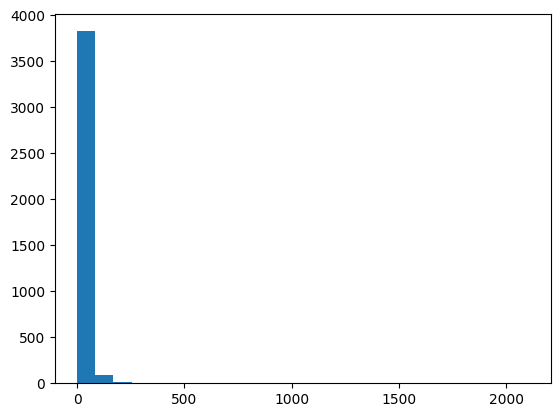

In [ ]:
plt.hist(trip_start_counts['count'], bins=25)

In [ ]:
trip_start_counts.describe()

,count
count,3939.000000
mean,15.482610
std,48.016296
min,1.000000
25%,2.000000
50%,5.000000
75%,14.000000
max,2104.000000


In [14]:
# create new qbc_dissemination area (if not it will crash)
qbc_dissemination_area_start = qbc_dissemination_area.merge(trip_start_counts, how = 'inner', on = 'DAUID')
del qbc_dissemination_area_start['count']
qbc_dissemination_area_start.head()

,DAUID,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,CSDUID,CSDNAME,CSDTYPE,ERUID,ERNAME,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,CTUID,CTNAME,ADAUID,geometry
0,24470215,24,Quebec / Québec,2447,La Haute-Yamaska,MRC,2447017,Granby,2447017,Granby,V,2435,Montérégie,450,2,450,24450,Granby,K,4500016.00,0016.00,24470002,"POLYGON ((-72.71006 45.44880, -72.71056 45.448..."
1,24460163,24,Quebec / Québec,2446,Brome-Missisquoi,MRC,2446112,Farnham,2446112,Farnham,V,2435,Montérégie,996,4,None,None,None,None,None,None,24460003,"POLYGON ((-72.97673 45.33241, -72.96654 45.325..."
2,24580103,24,Quebec / Québec,2458,Longueuil,TÉ,2458227,Longueuil,2458227,Longueuil,V,2435,Montérégie,462,1,462,24462,Montréal,B,4620882.00,0882.00,24580030,"POLYGON ((-73.49126 45.51461, -73.49173 45.513..."
3,24580104,24,Quebec / Québec,2458,Longueuil,TÉ,2458227,Longueuil,2458227,Longueuil,V,2435,Montérégie,462,1,462,24462,Montréal,B,4620881.02,0881.02,24580027,"POLYGON ((-73.49043 45.51588, -73.49084 45.515..."
4,24580105,24,Quebec / Québec,2458,Longueuil,TÉ,2458227,Longueuil,2458227,Longueuil,V,2435,Montérégie,462,1,462,24462,Montréal,B,4620881.01,0881.01,24580027,"POLYGON ((-73.48859 45.51865, -73.48897 45.518..."


In [48]:
m = folium.Map(location=[45.54629, -73.646385], width = '75%', height = '75%')

In [49]:
folium.Choropleth(
    geo_data = qbc_dissemination_area_start,
    data = trip_start_counts,
    columns = ['DAUID', 'count'],
    key_on = 'feature.properties.DAUID',
    fill_color = 'OrRd',
    fill_opacity = 0.9,
    legend_name='Trip Start Count By Dissemination Area'
).add_to(m)

folium.LayerControl().add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

####**choropleth - trip end**

In [ ]:
# create frequency count for trip starts by DAUID
trip_end_counts = mtl_trajet['DAUID_end'].value_counts().reset_index(name = 'count')
trip_end_counts = trip_end_counts.rename(columns= {'index' : 'DAUID'})
trip_end_counts['DAUID'] = trip_end_counts['DAUID'].astype(object)
trip_end_counts.head()

,DAUID,count
0,24661283,2341
1,24663442,714
2,24661858,566
3,24661104,557
4,24661256,532


In [ ]:
len(trip_end_counts)

3853

(array([3.77e+03, 6.40e+01, 4.00e+00, 6.00e+00, 2.00e+00, 4.00e+00,
        1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00]),
 array([1.0000e+00, 9.4600e+01, 1.8820e+02, 2.8180e+02, 3.7540e+02,
        4.6900e+02, 5.6260e+02, 6.5620e+02, 7.4980e+02, 8.4340e+02,
        9.3700e+02, 1.0306e+03, 1.1242e+03, 1.2178e+03, 1.3114e+03,
        1.4050e+03, 1.4986e+03, 1.5922e+03, 1.6858e+03, 1.7794e+03,
        1.8730e+03, 1.9666e+03, 2.0602e+03, 2.1538e+03, 2.2474e+03,
        2.3410e+03]),
 <a list of 25 Patch objects>)

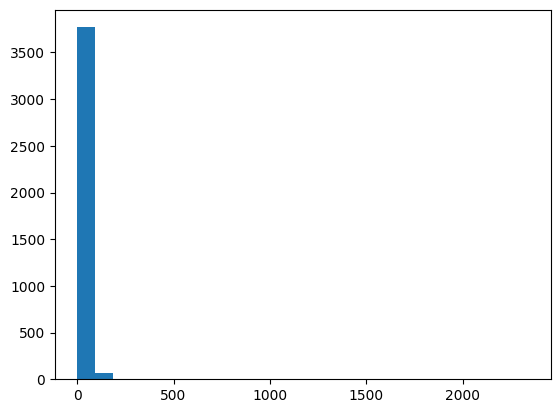

In [ ]:
plt.hist(trip_end_counts['count'], bins=25)

In [ ]:
trip_end_counts.describe()

,count
count,3853.000000
mean,15.829743
std,51.446850
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,2341.000000


In [ ]:
# create new qbc_dissemination area (if not it will crash)
qbc_dissemination_area_end = qbc_dissemination_area.merge(trip_end_counts, how = 'inner', on = 'DAUID')
del qbc_dissemination_area_end['count']
qbc_dissemination_area_end.head()

,DAUID,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,CSDUID,CSDNAME,CSDTYPE,ERUID,ERNAME,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,CTUID,CTNAME,ADAUID,geometry
0,24460163,24,Quebec / Québec,2446,Brome-Missisquoi,MRC,2446112,Farnham,2446112,Farnham,V,2435,Montérégie,996,4,None,None,None,None,None,None,24460003,"POLYGON ((-72.97673 45.33241, -72.96654 45.325..."
1,24580103,24,Quebec / Québec,2458,Longueuil,TÉ,2458227,Longueuil,2458227,Longueuil,V,2435,Montérégie,462,1,462,24462,Montréal,B,4620882.00,0882.00,24580030,"POLYGON ((-73.49126 45.51461, -73.49173 45.513..."
2,24580104,24,Quebec / Québec,2458,Longueuil,TÉ,2458227,Longueuil,2458227,Longueuil,V,2435,Montérégie,462,1,462,24462,Montréal,B,4620881.02,0881.02,24580027,"POLYGON ((-73.49043 45.51588, -73.49084 45.515..."
3,24580105,24,Quebec / Québec,2458,Longueuil,TÉ,2458227,Longueuil,2458227,Longueuil,V,2435,Montérégie,462,1,462,24462,Montréal,B,4620881.01,0881.01,24580027,"POLYGON ((-73.48859 45.51865, -73.48897 45.518..."
4,24580106,24,Quebec / Québec,2458,Longueuil,TÉ,2458227,Longueuil,2458227,Longueuil,V,2435,Montérégie,462,1,462,24462,Montréal,B,4620873.01,0873.01,24580025,"POLYGON ((-73.48645 45.51723, -73.48664 45.516..."


In [ ]:
g = folium.Map(location=[45.54629, -73.646385], width = '75%', height = '75%')

In [ ]:
folium.Choropleth(
    geo_data = qbc_dissemination_area_end,
    data = trip_end_counts,
    columns = ['DAUID', 'count'],
    key_on = 'feature.properties.DAUID',
    fill_color = 'BuPu',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name='Trip End Count By Dissemination Area'
).add_to(g)

folium.LayerControl().add_to(g)

g

Output hidden; open in https://colab.research.google.com to view.

####**scribbles**

   id_trip     DAUID                         geometry
1   173651  24730119  MULTIPOINT (-73.81487 45.64468)
          DAUID                                           geometry
15944  24730119  POLYGON ((-73.81614 45.64728, -73.81599 45.647...


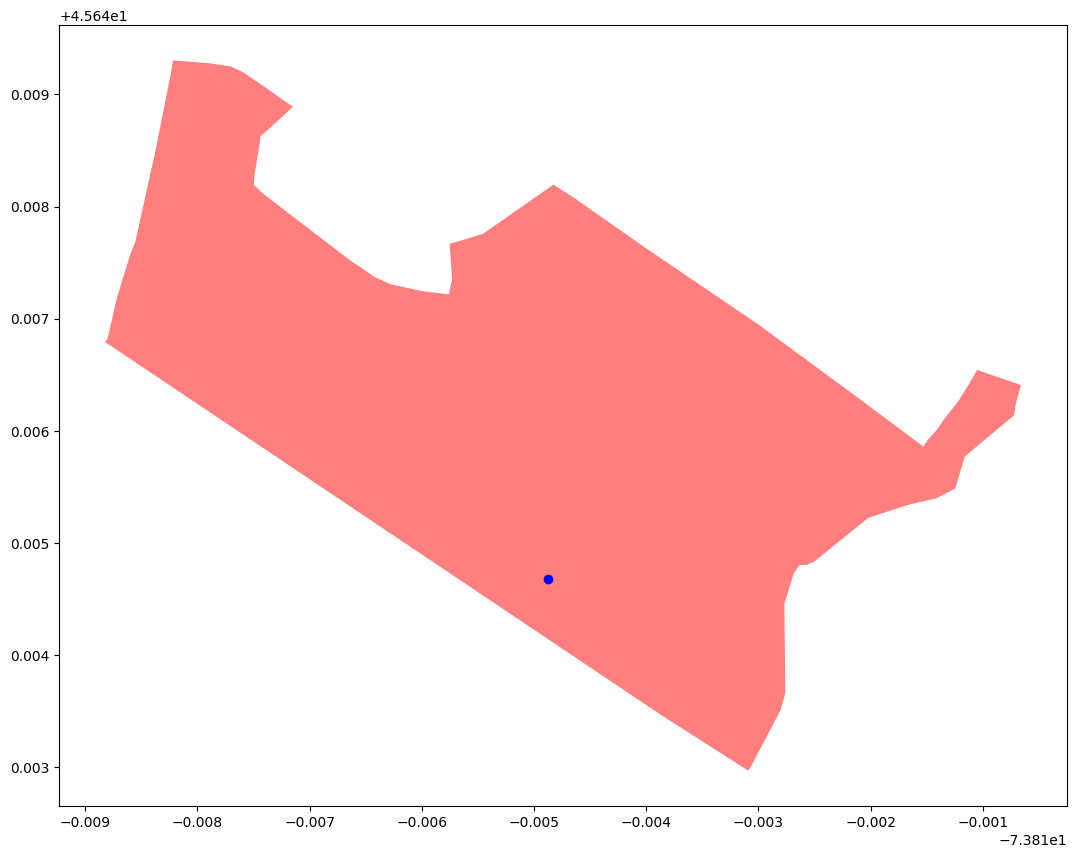

In [ ]:
# check
trip_id = 173651
trip_info = qgis_trip_start[['id_trip', 'DAUID', 'geometry']][qgis_trip_start['id_trip'] == trip_id]
trip_info['geometry'] = trip_info['geometry'].to_crs('epsg:4326')

print(trip_info)
DAUID_info = qbc_dissemination_area[['DAUID','geometry']][qbc_dissemination_area['DAUID'].isin(trip_info['DAUID'])]
DAUID_info.crs = 'epsg:4326'
DAUID_info['geometry'] = DAUID_info['geometry'].to_crs('epsg:4326')
print(DAUID_info)

# plot grid and SMT trips together
fig, ax = plt.subplots(figsize = (13,13))
DAUID_info.plot(ax = ax, color = 'r', alpha = 0.5)
trip_start.plot(ax = ax, color = 'b')
plt.show()